In [126]:
import pickle
from pathlib import Path
from easydict import EasyDict
import pandas as pd
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:
cfgs, btests = [], []
for p in sorted(Path("optimization").glob("*.pickle")):
    cfg, btest = pickle.load(open(p, "rb"))
    cfgs.append(cfg)
    btests.append(btest)
    # print(p)


In [128]:
opt_summary = {k:[] for k in cfgs[0].keys()}
for k in opt_summary.keys():
    for cfg in cfgs:
        v = cfg[k]
        if type(v) is EasyDict and "func" in v.keys():
            opt_summary[k].append(str(v.func.name))
        else:
            opt_summary[k].append(v)
            
opt_summary["btest"], opt_summary["ndeals"] = [], []
for btest in btests:
    opt_summary["btest"].append(btest.profits.sum())
    opt_summary["ndeals"].append(len(btest.profits))
    
opt_summary = pd.DataFrame(opt_summary)
opt_summary.sort_values(by=["btest"], ascending=False, inplace=True)
opt_summary = opt_summary[opt_summary.ticker != "NVTK"]
opt_summary.head(10)

,date_start,date_end,no_trading_days,trailing_stop_rate,trailing_stop_type,body_classifier,stops_processor,wait_entry_point,hist_buffer_size,tstart,tend,period,ticker,data_type,save_plots,run_model_device,btest,ndeals
88,2010-01-01,2024-01-01,{},0.020,1,saw:200-0,stops_fix:None-2,999,40,0,None,H1,ETHUSD,metatrader,False,None,789.057360,825
61,2010-01-01,2024-01-01,{},0.005,1,saw:100-0,stops_fix:None-3,999,40,0,None,H1,ETHUSD,metatrader,False,None,767.300331,356
76,2010-01-01,2024-01-01,{},0.010,1,saw:100-0,stops_fix:None-2,999,40,0,None,H1,ETHUSD,metatrader,False,None,740.131446,665
93,2010-01-01,2024-01-01,{},0.020,1,saw:100-0,stops_fix:None-3,999,40,0,None,H1,ETHUSD,metatrader,False,None,736.005032,754
84,2010-01-01,2024-01-01,{},0.020,1,saw:300-0,stops_fix:None-2,999,40,0,None,H1,ETHUSD,metatrader,False,None,731.947172,611
72,2010-01-01,2024-01-01,{},0.010,1,saw:200-0,stops_fix:None-2,999,40,0,None,H1,ETHUSD,metatrader,False,None,720.224025,625
89,2010-01-01,2024-01-01,{},0.020,1,saw:200-0,stops_fix:None-3,999,40,0,None,H1,ETHUSD,metatrader,False,None,704.219036,687
73,2010-01-01,2024-01-01,{},0.010,1,saw:200-0,stops_fix:None-3,999,40,0,None,H1,ETHUSD,metatrader,False,None,701.654262,511
60,2010-01-01,2024-01-01,{},0.005,1,saw:100-0,stops_fix:None-2,999,40,0,None,H1,ETHUSD,metatrader,False,None,695.569588,487
92,2010-01-01,2024-01-01,{},0.020,1,saw:100-0,stops_fix:None-2,999,40,0,None,H1,ETHUSD,metatrader,False,None,694.171989,905


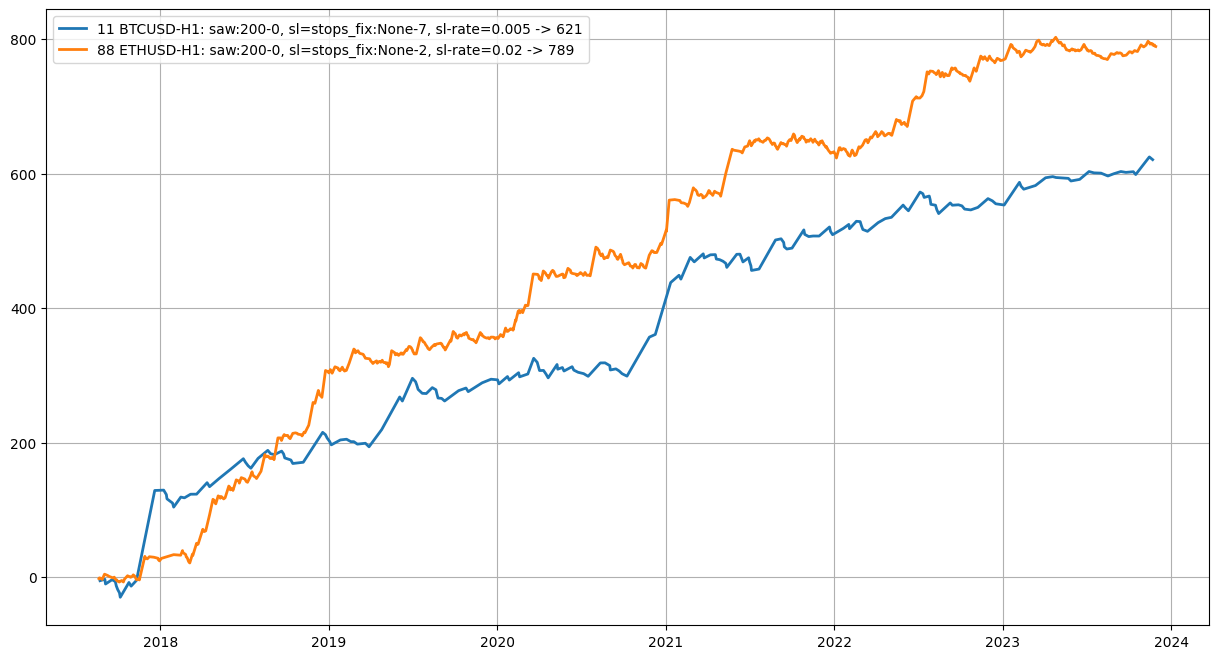

In [135]:
plt.figure(figsize=(15, 8))
opt_res_id = 0
tickers2plot = ["BTCUSD", "ETHUSD"]
test_ids2plot = []
legend = []
for ticker2plot in tickers2plot:
    btest_temp = opt_summary[opt_summary.ticker == ticker2plot]
    test_id = btest_temp.index[opt_res_id]
    line = btests[test_id].profits.cumsum()
    plt.plot([pos.close_date for pos in btests[test_id].positions], line, linewidth=2)
    legend.append(f"{test_id} {cfgs[test_id].ticker}-{cfgs[test_id].period}: {cfgs[test_id].body_classifier.func.name}, sl={cfgs[test_id].stops_processor.func.name}, sl-rate={cfgs[test_id].trailing_stop_rate} -> {line[-1]:.0f}")
plt.legend(legend)
plt.grid("on")

In [ ]:
opt_res = {"param_set":[], "ticker":[], "btest":[], "ndeals":[], "test_ids":[]}
for i in range(opt_summary.shape[0]):
    exphash, test_ids = "", ""
    for col in opt_summary.columns:
        if col not in ["ticker", "btest", "ndeals", "no_trading_days"]:
            exphash += str(opt_summary[col].iloc[i]) + " "
    opt_res["test_ids"].append(f".{opt_summary.index[i]}")
    opt_res["param_set"].append(exphash)
    opt_res["ticker"].append(f".{opt_summary.ticker.iloc[i]}")
    opt_res["ndeals"].append(opt_summary.ndeals.iloc[i])
    opt_res["btest"].append(opt_summary.btest.iloc[i])

opt_res = pd.DataFrame(opt_res)
opt_res = opt_res.groupby(by="param_set").sum()
opt_res.sort_values(by=["btest"], ascending=False, inplace=True)
opt_res.head(20)

In [ ]:
plt.figure(figsize=(15, 10))
opt_res_id = 0
legend = []
for test_id in map(int, opt_res.test_ids.iloc[opt_res_id].split(".")[1:]):
    plt.plot([pos.close_date for pos in btests[test_id].positions], 
             btests[test_id].profits.cumsum(), 
             linewidth=2)
    legend.append(cfgs[test_id].ticker)
plt.legend(legend)
plt.grid("on")